# Notebook for all simulations

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from check_warmup import avg_warmup_count, plot_avg_warmup_count

from environment import GLMBandit
from RS_GLBandit import RSGLBandit

### Warm-up Count for Rarely-Switching GLBandit

In [2]:
num_trials = 5
d=5
K=10
T=200000
kappa=50.0
R=1.0
S=5.0
lmbda=20.0
seed=186329

Running trial 1


100%|██████████| 200000/200000 [00:16<00:00, 12083.71it/s]


Running trial 2


100%|██████████| 200000/200000 [00:17<00:00, 11113.84it/s]


Running trial 3


100%|██████████| 200000/200000 [00:17<00:00, 11432.73it/s]


Running trial 4


100%|██████████| 200000/200000 [00:17<00:00, 11370.72it/s]


Running trial 5


100%|██████████| 200000/200000 [00:17<00:00, 11228.32it/s]


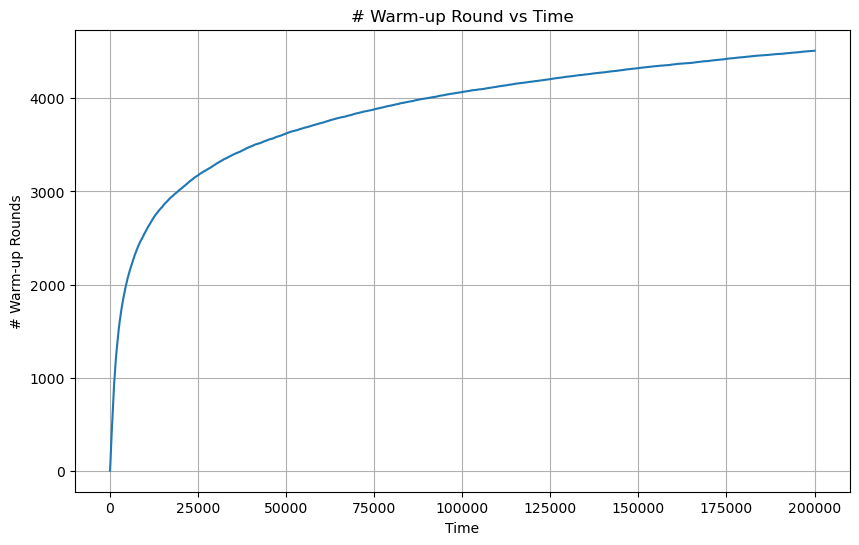

In [3]:
count = avg_warmup_count(num_trials, d, K, T, kappa, R, S, lmbda, seed)
plot_avg_warmup_count(count, show_flag=True)

### Logistic Model Simulation

In [2]:
def simulate(num_trials, env, algo_dict):
    algo_arr = []
    regret_dict = {k: np.zeros((env.T,)) for k in algo_dict.keys()}
    for n in range(num_trials):
        print('Simulating trial', n+1)
        for k in algo_dict.keys():
            if k == 'RS_GLBandit':
                lmbda = algo_dict[k]['lmbda']
                C = algo_dict[k]['C']
                wc = algo_dict[k]['wc']
                gm = algo_dict[k]['gm']
                algo = RSGLBandit(env.get_first_action_set(), lmbda, C, wc, gm, env.kappa, env.R, env.S, env.model)
            algo_arr.append(algo)
    
        for t in tqdm(range(env.T)):
            act_arr = []
            for algo in algo_arr:
                act_arr.append(algo.play_arm())
            rewards, regrets, next_arm_set = env.step(act_arr)

            for j, algo in enumerate(algo_arr):
                algo.update(rewards[j], regrets[j], next_arm_set)
        
        for algo in algo_arr:
            if type(algo) is RSGLBandit:
                regret_dict['RS_GLBandit'] += np.array(algo.regret_arr)
        env.reset()
    
    for k in regret_dict.keys():
        regret_dict[k] /= num_trials
    
    return regret_dict


In [3]:
def plot_regret(rg_dict, T):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    T_arr = np.arange(1, T+1)
    for k in rg_dict.keys():
        ax.plot(T_arr, np.cumsum(rg_dict[k]), label=k)
    ax.legend()
    ax.grid()
    ax.set_xlabel('Time')
    ax.set_ylabel('Regret')
    ax.set_title('Regret vs Time')
    plt.show()

In [4]:
config = {}
config['seed'] = 109832
config['model'] = 'Logistic'
config['theta_dim'] = 3
config['num_arms'] = 10
config['theta_norm'] = 1.0
config['horizon_length'] = 500000

env = GLMBandit(config=config)
print('Kappa =', env.kappa)

Kappa = 4.3147768156146125


In [5]:
algo_dict = {'RS_GLBandit': {'lmbda': 0.01, 'wc': 0.01, 'C': 0.5, 'gm': 0.001}}

Simulating trial 1


  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 129/500000 [00:00<06:30, 1279.63it/s]

Warm up round at step 1
Warm up round at step 2
Warm up round at step 3
Warm up round at step 11


  0%|          | 1144/500000 [00:00<04:54, 1693.97it/s]

Warm up round at step 900


  1%|▏         | 6324/500000 [00:03<05:09, 1597.60it/s]

Warm up round at step 6051


 13%|█▎        | 65953/500000 [00:38<03:51, 1872.10it/s]

Warm up round at step 65705


100%|██████████| 500000/500000 [04:39<00:00, 1787.82it/s]


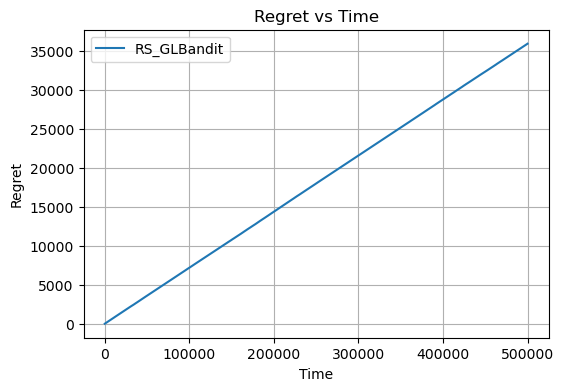

In [6]:
regret_dict = simulate(1, env, algo_dict)
plot_regret(regret_dict, env.T)